# SENTIMENT ANALYSIS AND OPINION MINING PROJECT
## PUBLIC OPINION ON NEWS

https://island.ricerca.di.unimi.it/~alfio/shared/textsent/2020-21/projects.html

The New York Times Comments dataset (https://www.kaggle.com/aashita/nyt-comments?select=CommentsApril2017.csv) contains articles published on the New York Times and the comments they received from readers. <br>
The task of the project is to analyze, using the variables *editorsSelection*, *recommendations*, and *replyCount* as targets, the rate of success of a comment. This rate of success should be intepreted as a measure of how much controversial was the commented article. On this base, the project aims at studing which topics (indicated by the features sectionName and/or newDesk) were mostly controversial. Optionally, the project could also determine if a comment opinion is against or if favor of the article.

# 3. TOPICS CONTROVERSY ANALYSIS
The controversy of topics (variables *newDesk* and *sectionName*) will be analysed and graphically explored. Two summary variables are created from the original 3 targets:
- Binary summary variable: it takes value 1 if there is at least a positive label or else 0 
- Multiclass summary variable: it takes value equal to the number of positive labels

In [2]:
import seaborn as sns
import matplotlib.pylab as plt
import pickle
from tqdm.auto import tqdm
import time
import itertools
import functools
import operator
import time
from collections import defaultdict
import os

from glob import glob
import os
import json
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

In [59]:
X = pd.read_csv('data/dataset_cleansed_version.csv')
X = X[['editorsSelection_TARGET','recommendations_TARGET','replyCount_TARGET','sectionName_x','newDesk_x']]

# create the summary multiclass variable, which takes value equal to the number of positive labels
X['Summary_TARGET_multiclass'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1)
# create the summary binary variable which takes value 1 if there is at least a positive label or else 0 
X['Summary_TARGET_binary'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1).apply(lambda x: 1 if x>=1 else 0)

In [53]:
def show_controversy(X, topics_variable, binary=True):

    # count the different labels for each topic
    if binary:
        freq_X = pd.DataFrame(X.groupby([topics_variable,'Summary_TARGET_binary']).count().iloc[:,0])
    else:
        freq_X = pd.DataFrame(X.groupby([topics_variable,'Summary_TARGET_multiclass']).count().iloc[:,0])
        
    freq_X.columns = ['count']
    # retrieve percentage of labels for each topic
    freq_X = freq_X / freq_X.groupby(topics_variable).sum()
    freq_X.reset_index(level=[0,1], inplace=True)
    
    # add a missing level in the sectionName_x variable
    if topics_variable=='sectionName_x':
        freq_X.loc[-1] = ['Opinion | The World', 0, 0.0]
    
    if binary:
        # select the topics with more than 60% of controversial comments (label=1)
        controversial_topics = freq_X[topics_variable][(freq_X['Summary_TARGET_binary']==1) & (freq_X['count']>=0.6)]
        freq_X = freq_X[freq_X[topics_variable].isin(list(controversial_topics))]
        # order the topics by the percentage of controversial comments
        ordered_freq = freq_X[freq_X['Summary_TARGET_binary']==1].sort_values(by='count', ascending=False)[topics_variable]
    
    
    else:
        # select the topics in newDesk with less than 40% of non-controversial comments (label=0)
        controversial_topics = freq_X[topics_variable][(freq_X['Summary_TARGET_multiclass']==0) & (freq_X['count']<0.4)]
        freq_X = freq_X[freq_X[topics_variable].isin(list(controversial_topics))]
        # order the topics by the percentage of controversial comments
        ordered_freq = freq_X[freq_X['Summary_TARGET_multiclass']==0].sort_values(by='count', ascending=True)[topics_variable]
    

    import seaborn as sns
    sns.set_theme(style="darkgrid")
    sns.set(rc={'figure.figsize':(30,15)})
    
    if binary:
        ax = sns.barplot(x=topics_variable,y='count',hue='Summary_TARGET_binary', data=freq_X, 
                         palette=["#5de38d", "#e03453"], order=ordered_freq)
        ax.set_title("Frequency barplot of {} (controversial vs. not controversial)".format(topics_variable),fontsize=40)
        
    else:
        ax = sns.barplot(x=topics_variable,y='count',hue='Summary_TARGET_multiclass', data=freq_X, 
                 palette=["#5de38d", "#faf252", "#fa9025","#e03453"], order=ordered_freq)
        ax.set_title("Frequency barplot of {} (4 levels of controversy)".format(topics_variable),fontsize=40)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=25,rotation=45, horizontalalignment='right')
    plt.setp(ax.get_legend().get_texts(), fontsize='25')
    plt.setp(ax.get_legend().get_title(),fontsize=25)
    ax.tick_params(axis="y", labelsize=20)
    

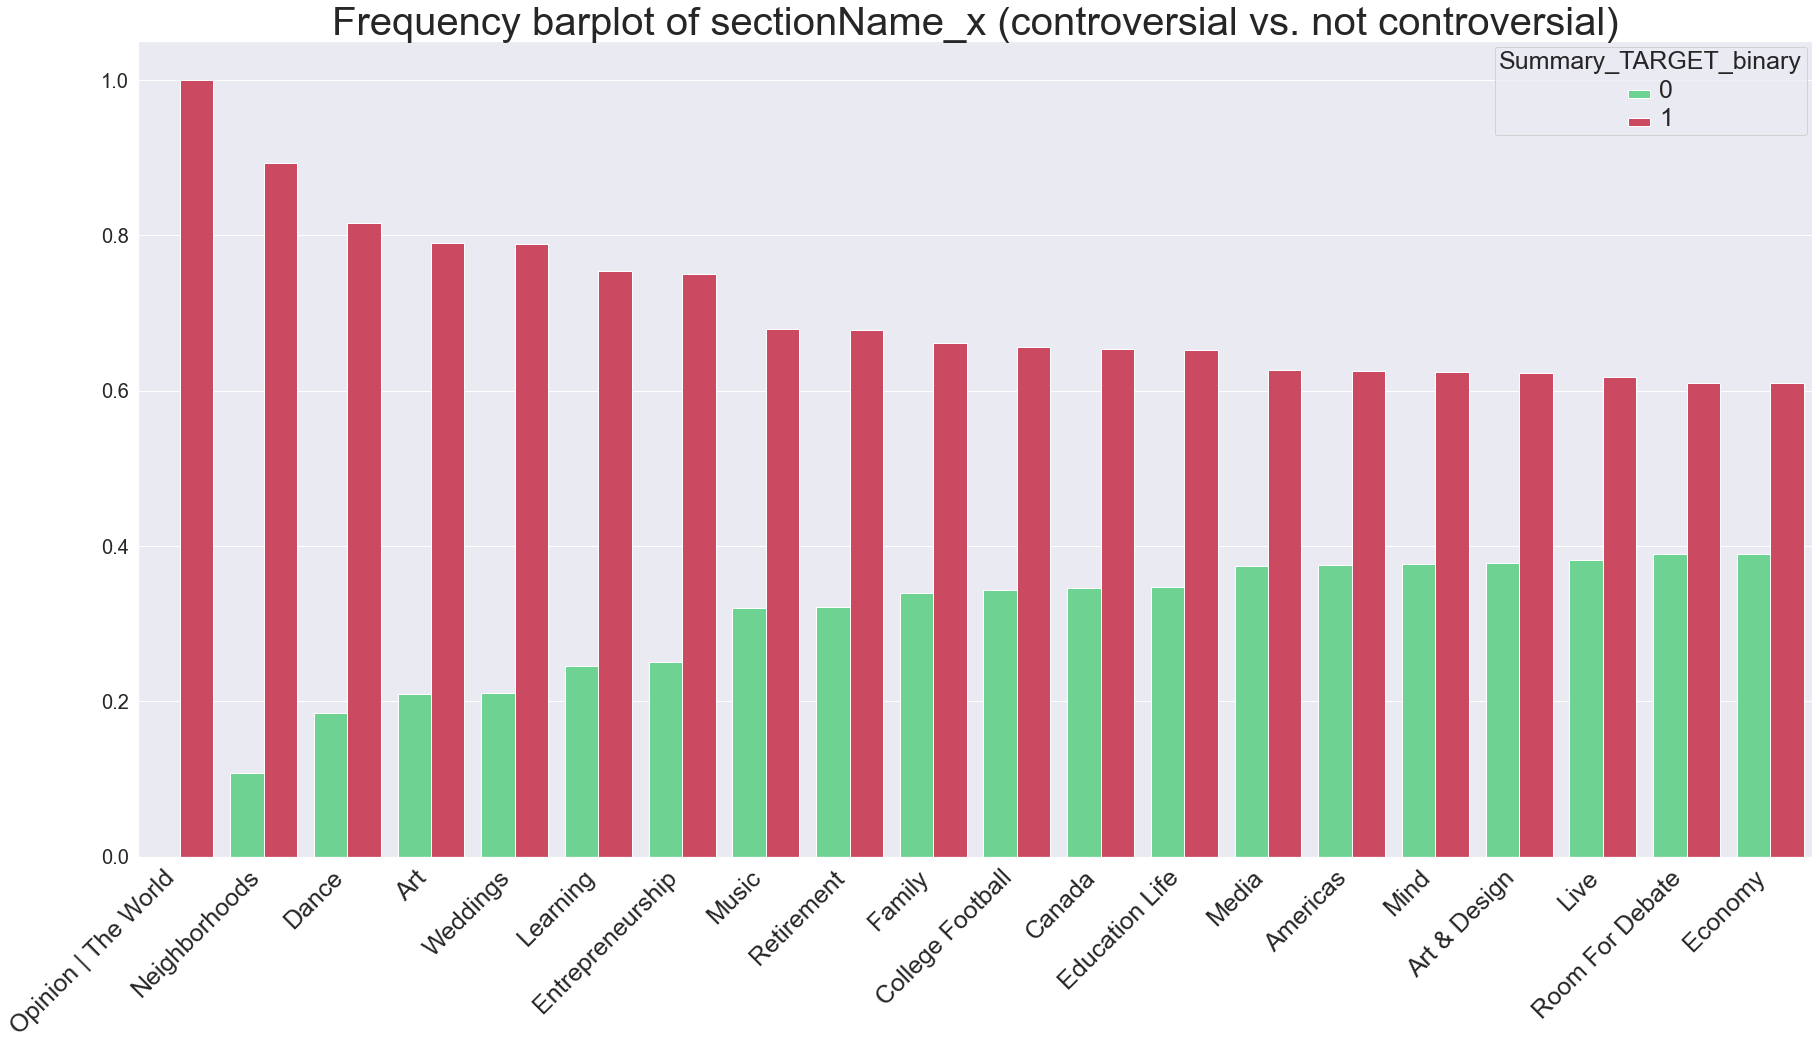

In [54]:
show_controversy(X, topics_variable='sectionName_x', binary=True)

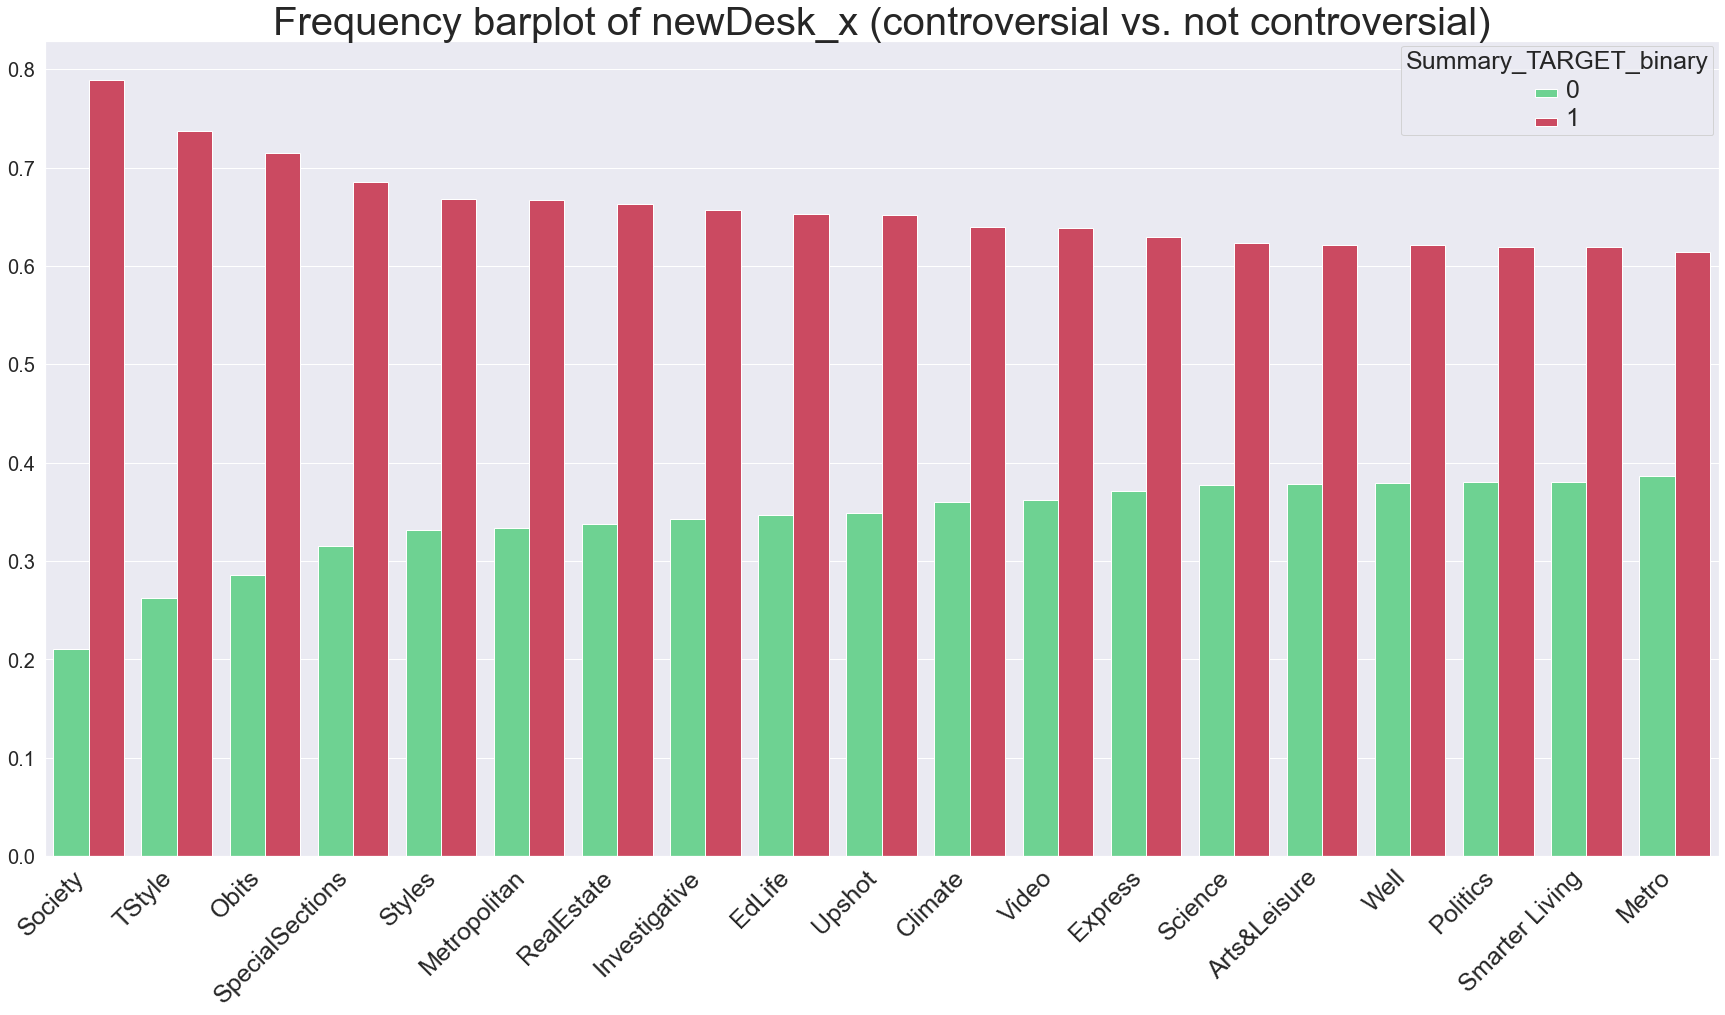

In [55]:
show_controversy(X, topics_variable='newDesk_x', binary=True)

---
Now we do the same by using the different levels of controversy, in order to see how the classes are distributed over the controversial comments

As before we discard all the topics having more than 40% of non-controversial comments

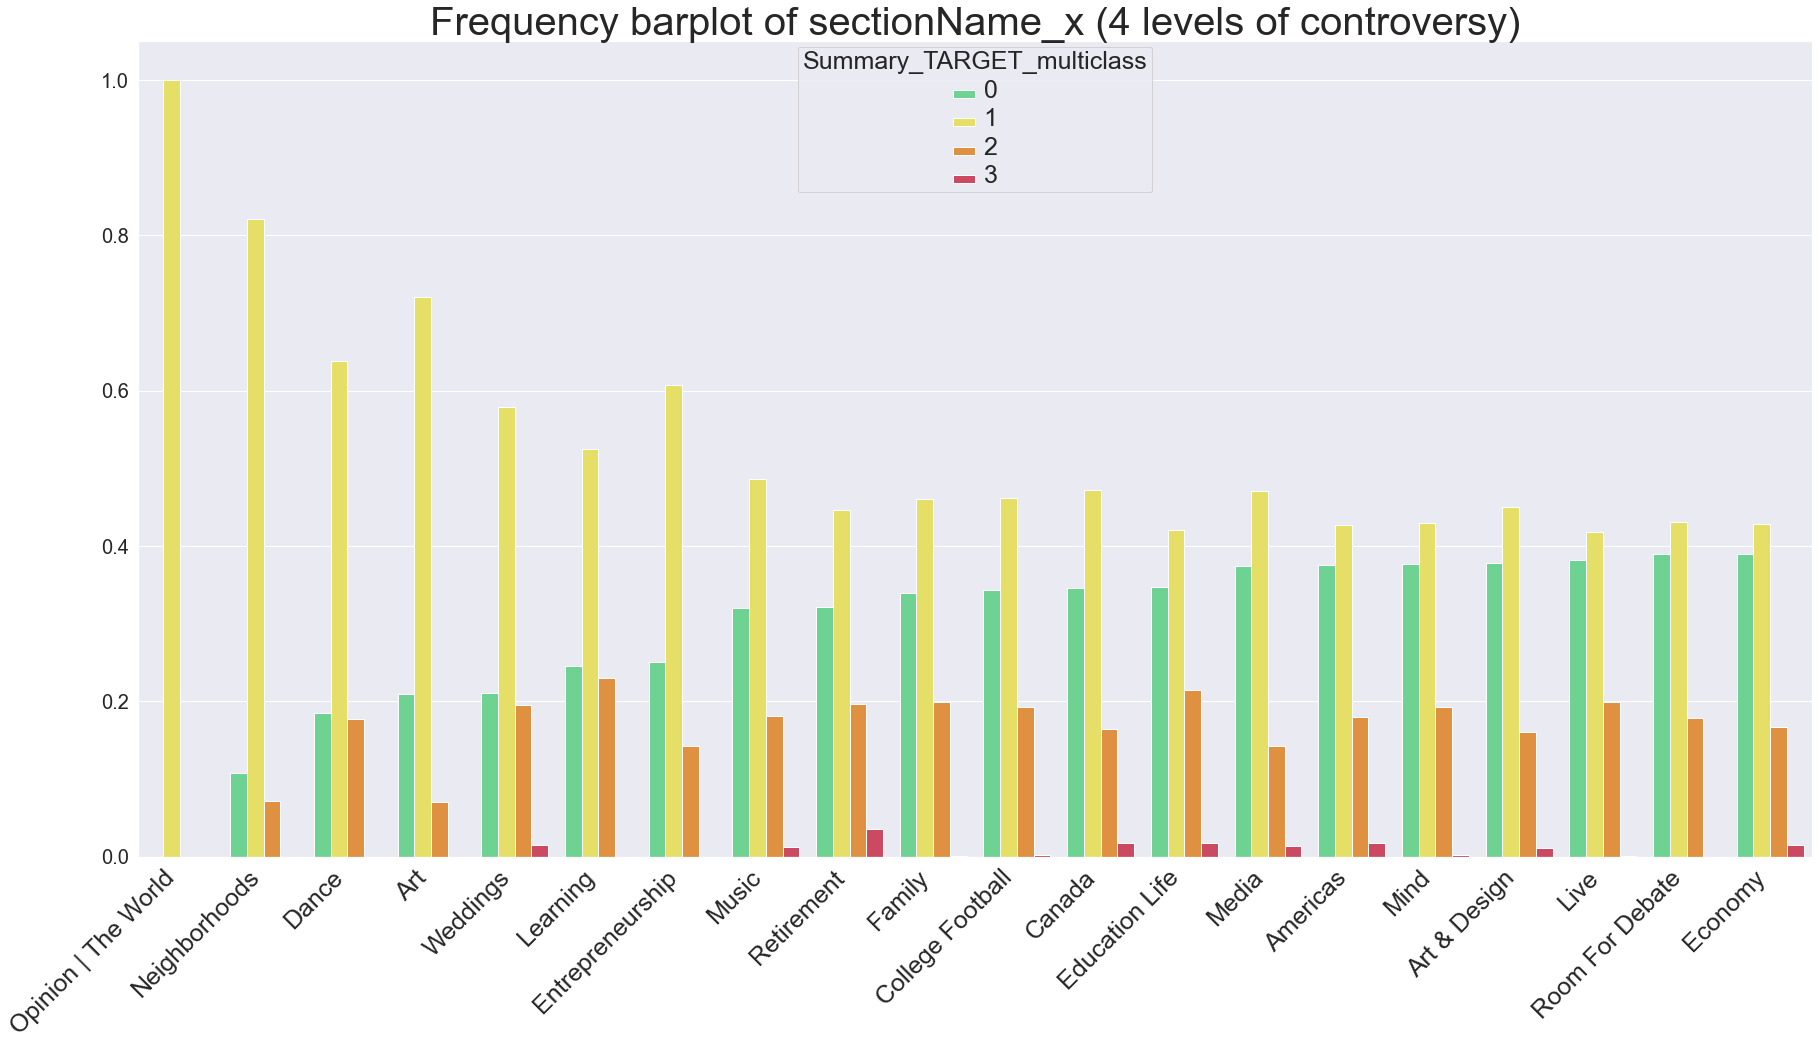

In [57]:
show_controversy(X, topics_variable='sectionName_x', binary=False)

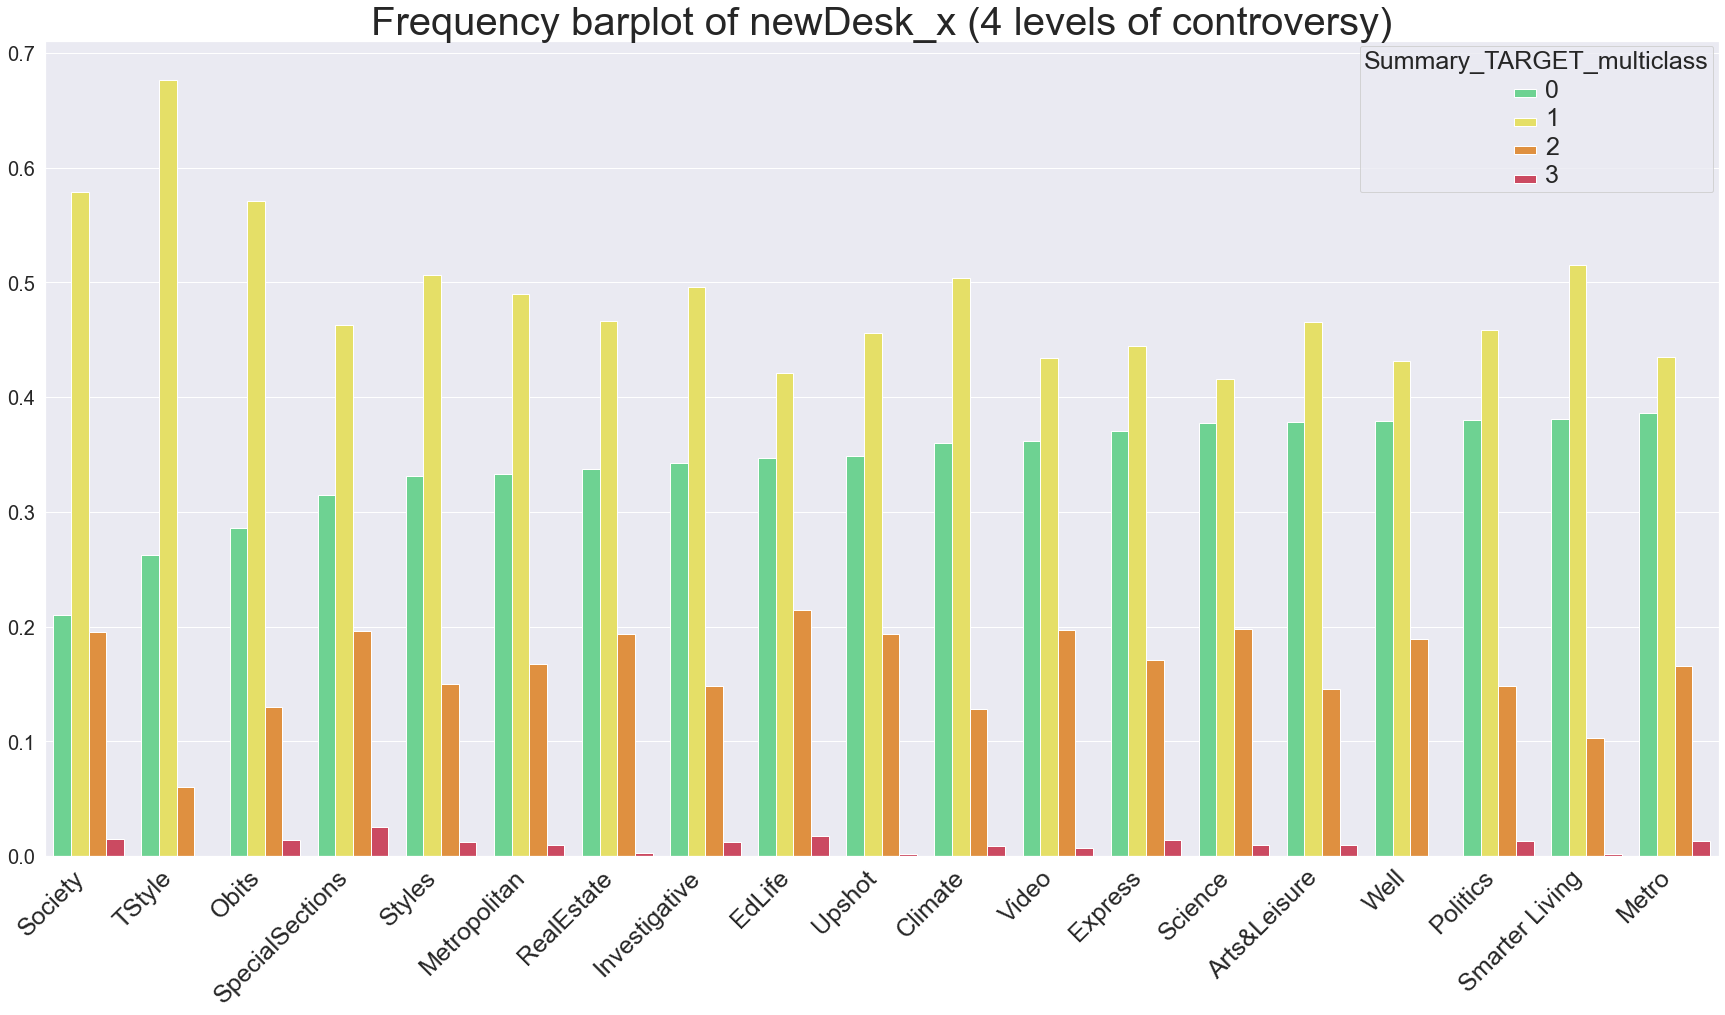

In [58]:
show_controversy(X, topics_variable='newDesk_x', binary=False)